In [30]:
import pandas as pd
import numpy as np
import ast

data = pd.read_csv("/content/challenge3.csv")
ack = pd.read_csv("/content/ack_log.csv")
filtered_pubs = pd.read_csv("/content/filtered_pubs.csv")
id_log = pd.read_csv("/content/id_log.csv")



In [31]:
data

,No.,Time,Source,Destination,Protocol,Length,Source Port,Destination Port,Info,Payload
0,1,1.631806,10.0.2.15,3.65.137.17,MQTT,79,34039,1883,Connect Command,NaN
1,2,1.633054,10.0.2.15,3.65.137.17,MQTT,85,47723,1883,Connect Command,NaN
2,3,1.656703,3.65.137.17,10.0.2.15,MQTT,62,1883,34039,Connect Ack,NaN
3,4,1.666551,10.0.2.15,91.121.93.94,MQTT,80,43133,1883,Connect Command,NaN
4,5,1.673415,3.65.137.17,10.0.2.15,MQTT,67,1883,47723,Connect Ack,NaN
...,...,...,...,...,...,...,...,...,...,...
7706,7707,2397.304498,52.29.173.150,10.0.2.15,MQTT,62,1883,55677,Ping Response,NaN
7707,7708,2401.957147,10.0.2.15,52.29.173.150,MQTT,58,60609,1883,Ping Request,NaN
7708,7709,2401.972165,52.29.173.150,10.0.2.15,MQTT,62,1883,60609,Ping Response,NaN
7709,7710,2406.326562,10.0.2.15,3.65.137.17,MQTT,58,34039,1883,Ping Request,NaN


In [32]:
ack

,timestamp,sub_id,msg_type
0,1713291092597,989,Publish Ack (id=25)
1,1713291227495,632,Publish Ack (id=10)
2,1713291322542,101,Subscribe Ack (id=6)
3,1713291372558,623,Publish Ack (id=8)
4,1713291487605,118,Subscribe Ack (id=3)


In [33]:
filtered_pubs

,no,long,range,lat,type,unit,description
0,0,48,"[4,37]",53,temperature,F,Room Temperature
1,1,96,"[1,47]",58,temperature,F,Room Temperature
2,2,90,"[9,42]",51,temperature,F,Room Temperature
3,3,76,"[4,58]",55,temperature,F,Room Temperature
4,4,53,"[5,55]",95,temperature,F,Room Temperature
5,5,73,"[5,43]",64,temperature,F,Room Temperature
6,6,53,"[5,55]",95,temperature,F,Room Temperature
7,7,85,"[7,38]",77,temperature,F,Room Temperature
8,8,82,"[0,45]",80,temperature,F,Room Temperature
9,9,81,"[8,31]",62,temperature,F,Room Temperature


In [34]:
id_log

,no,id,timestamp
0,0,989.035358,1713291091628
1,1,1008.288355,1713291096629
2,2,845.755437,1713291101634
3,3,2964.450454,1713291106635
4,4,1154.187637,1713291111639
...,...,...,...
76,76,1807.197649,1713291471794
77,77,3600.193561,1713291476799
78,78,3810.155484,1713291481799
79,79,118.900233,1713291486801


In [35]:
def check_ack(sub_id):
  if not sub_id in ack_list:
    raise Exception("missing ack for id:", sub_id)

def check_pub(payload, id):
  n = 0
  tmp=False
  for p in payload:
    if p.get("unit") == "F" and p.get("type") ==  "temperature":
      for i in range(0, len(filtered_pubs)):
        if p.get("long") == filtered_pubs["long"][i] and p.get("lat") == filtered_pubs["lat"][i] and p.get("description") == filtered_pubs["description"][i]:
          tmp=True
          n+=1
          break
      #print(id, i, p)
      if(tmp==False): raise Exception("expected tupla from message with id %d in filtered_pubs" %id)
  return n

In [36]:
def _color_red_or_green(val):
    color = 'red' if val == False else 'green'
    return 'color: %s' % color


In [37]:
ack_list = ack["sub_id"].to_list()
ack_n = 0

pubs_n = 0

output_table = pd.DataFrame()
id = 0

for i in range(0, len(id_log)):
  id = int(id_log["id"][i] % 7711)
  type = "others"
  response = "🟢"

  for j in range(0, len(data)):
    if  data["No."][j] == id and "Ack" in data["Info"][j]:
      type = data["Info"][j]
      try:
        check_ack(id)
      except:
        response = "🔴"

      ack_n +=1
    elif data["No."][j] == id and "Publish Message" in data["Info"][j]:
      type = "Publish Message"
      if( not pd.isna(data["Payload"][j])):
        try:
          new_pubs = check_pub(ast.literal_eval("["+data["Payload"][j]+"]"), id)
        except:
          response = "🔴"
        if new_pubs != 0:
          type = "Publish Message [K]"
        pubs_n += new_pubs

  save_output = {'id': id, 'type': type, 'response': response}
  output_table = pd.concat([output_table, pd.DataFrame([save_output])], ignore_index=True)


if len(ack_list) != ack_n:
  print("you have %d ack message saved but expected ack numbers is" % ack_n, len(ack_list))


if len(filtered_pubs) != pubs_n:
  print("you have %d pub message saved but expected pub numbers is" % len(filtered_pubs), pubs_n)

output_table.style.highlight_max(axis=0).set_properties( **{'width': '30px'},**{'text-align': 'center'})
#output_table.style.applymap("background-color: red")
display(output_table)


,id,type,response
0,989,Publish Ack (id=25),🟢
1,1008,others,🟢
2,845,Publish Message [K],🟢
3,2964,Publish Message,🟢
4,1154,Publish Message [K],🟢
...,...,...,...
76,1807,others,🟢
77,3600,Publish Message,🟢
78,3810,Publish Message,🟢
79,118,Subscribe Ack (id=3),🟢


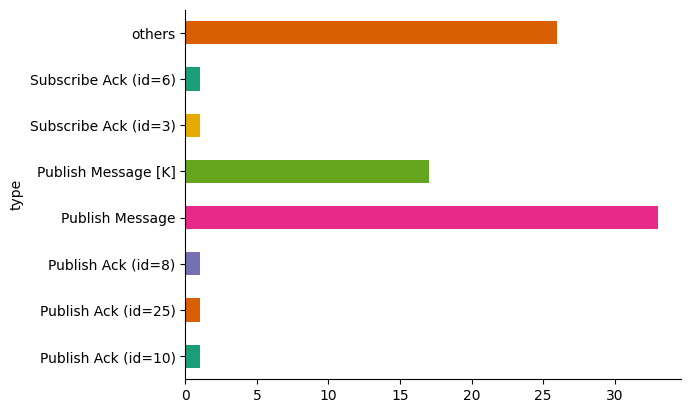

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
output_table.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)